# Hot Dog or Not Hot Dog

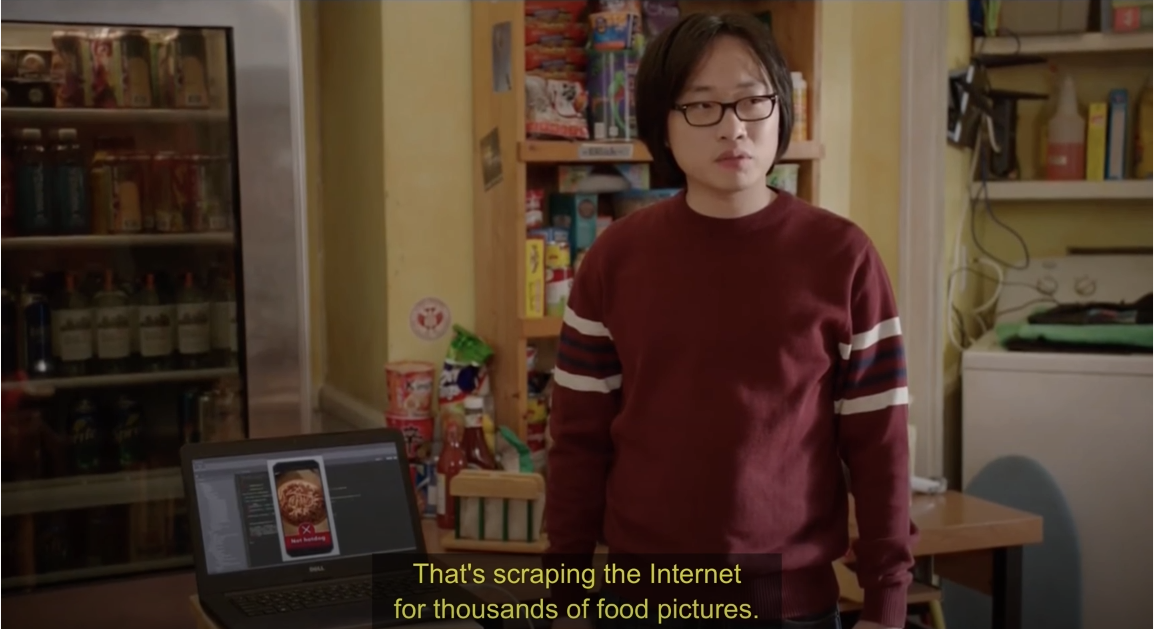

If you have watched Silicon Valley TV show on HBO, you probably know the amazing Seefood app created by Jian Yang to identify whether an object is hot dog or not. For those who don't know or those who need to refresh their memories, watch the following [video](https://www.youtube.com/watch?v=vIci3C4JkL0). It may bring us the laugh as we think the app be useless and simple, but such "simple" task cannot be done without major advances in Deep Learning in the past 5-6 years.

Therefore, in this project we will try to imitate the app and hopefully to impress Erlich Bachman. Luckily, there is hotdog/not hotdog dataset posted on [Kaggle](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog). We will first implement a normal L-layered fully connected neural network as a benchmark, then we apply different Convolutional Neural Networks(CNN) models including:

- AlexNet
- VGG16
- MobileNetV2
- ResNet50


## Import Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

In [2]:
#Check tensorflow version
tf.__version__

'2.7.0'

## Import the Dataset

We define __load_dataset()__ function to load both train and test datasets. Depending on the model chosen, image size is set accordingly to match with the image size used in each model's paper. 

| Model | IMAGE_SIZE|
|:------  |:----------|
| Dense (benchmark)   | (64,64) |
| AlexNet | (227,227) |
| ResNet50| (224,224) |
| VGG16   | (224,224) |
| MobileNetV2| (160,160)|


In [3]:
def load_dataset(model, batch_size = 32):
    if model == "Dense":
        IMAGE_SIZE = (64,64)
    elif model == "AlexNet":
        IMAGE_SIZE = (227,227)
    elif model == "MobileNet":
        IMAGE_SIZE = (160, 160)
    elif model == "ResNet50" or model == "VGG16":
        IMAGE_SIZE = (224,224)
     
    directory = "dataset/"

#     train_dataset = image_dataset_from_directory(directory + "train",
#                                                 shuffle = True,
#                                                 batch_size = batch_size,
#                                                 image_size = IMAGE_SIZE,
                                    
#                                                 seed = 0)

#     validation_dataset = image_dataset_from_directory(directory + "test",
#                                                 shuffle = False,
#                                                 batch_size = batch_size,
#                                                 image_size = IMAGE_SIZE,
 
#                                                 seed = 0)
    
    train_datagen = ImageDataGenerator(
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
    
    #validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator()
    
    train_dataset = train_datagen.flow_from_directory(
                        directory +"train/",
                        target_size = IMAGE_SIZE,
                        batch_size = batch_size,
                        class_mode ='binary',
                        seed = 44)
    
    validation_dataset = validation_datagen.flow_from_directory(
                        directory + "test/",
                        target_size = IMAGE_SIZE,
                        batch_size = batch_size,
                        class_mode ='binary',
                        seed = 44)
    
    return (train_dataset, validation_dataset)


In [4]:
# load datasets to plot some examples
train_dataset, validation_dataset = load_dataset("MobileNet")
class_names = train_dataset.class_indices
print(class_names)

Found 3000 images belonging to 2 classes.
Found 644 images belonging to 2 classes.
{'hotdog': 0, 'not_hot_dog': 1}


## Plot some examples

In [5]:
# plt.figure(figsize=(10,10))
# for images, labels in train_dataset.next():
#     for i in range(9):
#         ax = plt.subplot(3,3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

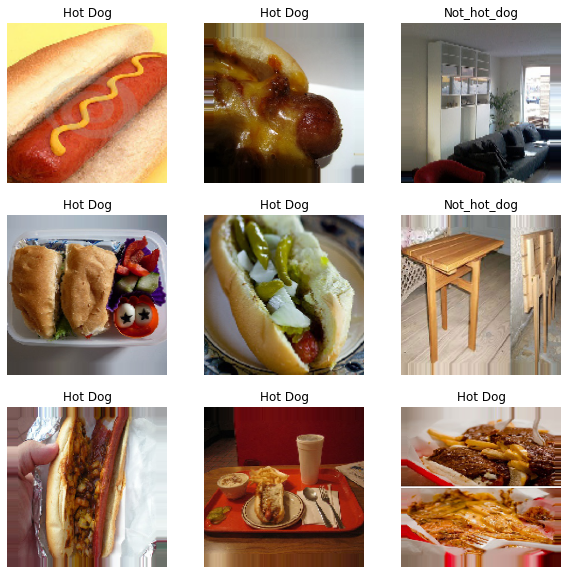

In [6]:
plt.figure(figsize=(10,10))
batch = next(train_dataset)

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    img = batch[0][i]/255.0
    plt.imshow(img)
    label = "Hot Dog" if batch[1][i] == 0 else "Not_hot_dog"
    plt.title(label)
    plt.axis("off")

## Data Augmentation

In [7]:
# def data_augmenter():
#     data_augmentation = tf.keras.Sequential([
#         tf.keras.layers.RandomFlip('horizontal'),
#         tf.keras.layers.RandomRotation(0.3)
#     ])
   
#     return data_augmentation

In [8]:
# data_augmentation = data_augmenter()

# for image, _ in train_dataset.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) #RandomFlip and RandomRotation 
#                                                                             #require 4-dimension input 
#         plt.imshow(augmented_image[0] / 255)
#         plt.axis('off')

## Utility Functions

We are going to create 2 functions that will be repeatedly used for the rest of the project:

- __plot_accuracy_loss()__: This function takes 1 argument which is the history results from fit() function of a Keras model and plot train/validation loss and accuracy.

- __train_and_evaluate()__: This function performs the following tasks:
    - Load the training and validation dataset based on the model's type.
    - Train and evaluate the model.
    - Call __plot_accuracy_loss()__ to plot the results

In [9]:
def plot_accuracy_loss(history):
    training_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    training_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(training_acc , label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(val_loss, label = 'Validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Cross Entropy)')

In [10]:
EPOCHS = 10
learning_rate = 0.001
def train_and_evaluate(model_type, model, epochs= EPOCHS, lr = learning_rate):
    train_ds, validation_ds = load_dataset(model_type)
    
    #AUTOTUNE = tf.data.experimental.AUTOTUNE
    #train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    
    model.compile(optimizer= Adam(learning_rate = lr),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs)
    plot_accuracy_loss(history)
    return ((train_ds, validation_ds), history)
    

## Dense (Fully-connected Neural Network) - Benchmark

First model implemented is a normal fully connected neural network to give us some benchmark. A summary of this network's configuration is shown below:

| Layer| Size(number of units)| Activation|
|:------  |:----------|:----|
|Input | 64 x 64 = 4096 | N/A|
|1st hidden| 2048| ReLU|
|2nd hidden| 1024 | ReLU|
|3rd hidden| 512 | ReLU|
|Output     | 1     | Sigmoid|

In [11]:
def dense_nn(n_h, image_shape = (64,64,3)):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape= image_shape),
        #data_augmentation,
        tf.keras.layers.Rescaling(1./255),
        Flatten(),    
        Dense(n_h, activation='relu'),
        Dropout(0.2),
        Dense(n_h/2, activation='relu'),
        Dropout(0.2),
        Dense(n_h/4, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

In [12]:
dense_model = dense_nn(2048)
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 2048)              25167872  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               5

Found 3000 images belonging to 2 classes.
Found 644 images belonging to 2 classes.
Epoch 1/15
94/94 [==============================] - 19s 192ms/step - loss: 0.7784 - accuracy: 0.5160 - val_loss: 0.9086 - val_accuracy: 0.5000
Epoch 2/15
94/94 [==============================] - 14s 154ms/step - loss: 0.7395 - accuracy: 0.5193 - val_loss: 0.6742 - val_accuracy: 0.5947
Epoch 3/15
94/94 [==============================] - 15s 157ms/step - loss: 0.7009 - accuracy: 0.5490 - val_loss: 0.6719 - val_accuracy: 0.5637
Epoch 4/15
94/94 [==============================] - 15s 156ms/step - loss: 0.6845 - accuracy: 0.5710 - val_loss: 0.6692 - val_accuracy: 0.5512
Epoch 5/15
94/94 [==============================] - 15s 157ms/step - loss: 0.6832 - accuracy: 0.5920 - val_loss: 0.6739 - val_accuracy: 0.5901
Epoch 6/15
94/94 [==============================] - 15s 158ms/step - loss: 0.6772 - accuracy: 0.5800 - val_loss: 0.6491 - val_accuracy: 0.6087
Epoch 7/15
94/94 [==============================] - 15s 161

((<keras.preprocessing.image.DirectoryIterator at 0x1d334f9ea60>,
  <keras.preprocessing.image.DirectoryIterator at 0x1d334f01820>),
 <keras.callbacks.History at 0x1d334f99d90>)

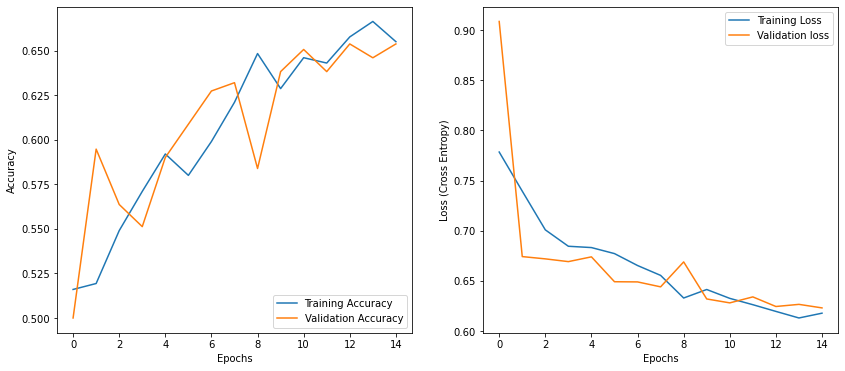

In [13]:
train_and_evaluate("Dense", dense_model, 15,lr=1e-4)

## Define AlexNet model

Since there is no pre-built AlexNet model in Keras, we are going to define our own AlexNet based on the description in the [paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). The only difference between the original and our own model is that instead of a 1000-class softmax at the output, our model only has a single unit with sigmoid as activation.

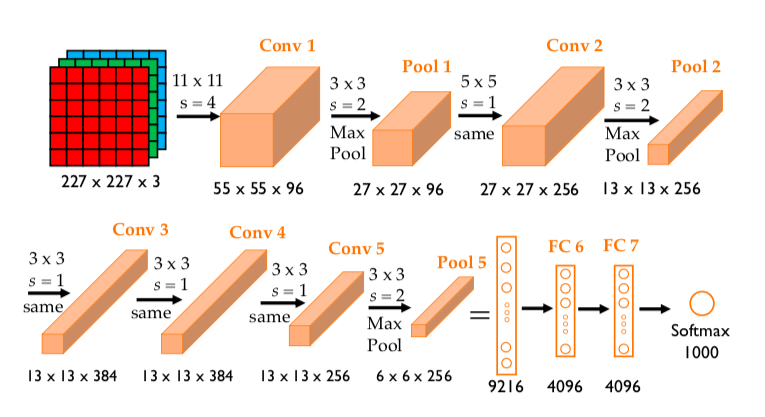



In [14]:
def AlexNet(image_shape=(227,227,3)):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=image_shape),
        #data_augmentation,
        tf.keras.layers.Rescaling(1./255),
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.2),
        Dense(4096, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    return model

## Define a generic hotdog_model

The __hotdog_model()__ function returns one model among: MobileNet, AlexNet, ResNet50 and VGG16 chosen by the user:
- If AlexNet selected, no further modification needed
- For other models, we exclude the top layer (i.e the final output layer) and add a GlobalAveragePooling and Dropout layer. At the end we add a single neuron for binary classification. We also load the corresponding __tf.keras.applications.\[model\].preprocess_input__ for each model to make sure that the inputs are preprocessed properly 


In [15]:
def hotdog_model(model_type, image_shape):
    
    #load a pre-trained CNN model, exclude the top layer i.e the classification layer
    if model_type == "MobileNet":
        base_model = tf.keras.applications.MobileNetV2(input_shape= image_shape,
                                                   include_top = False,
                                                   weights='imagenet')
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    
    elif model_type == "AlexNet":
        base_model = AlexNet()
        return base_model
    
    elif model_type == "VGG16":
        base_model = tf.keras.applications.VGG16(input_shape= image_shape,
                                                   include_top = False,
                                                   weights='imagenet')
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
     
    elif model_type == "ResNet50":
        base_model = tf.keras.applications.ResNet50(input_shape= image_shape,
                                                   include_top = False,
                                                   weights='imagenet')
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

      
    inputs = tf.keras.Input(shape = image_shape)
    #x = data_augmentation(inputs)
    
    x = preprocess_input(inputs)
    
    #set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model
    

## Train and Evaluate each model

### 1. AlexNet

In [18]:
IMAGE_SHAPE = (227, 227,3)
alexNet_model = hotdog_model("AlexNet", IMAGE_SHAPE)
alexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)     

Found 3000 images belonging to 2 classes.
Found 644 images belonging to 2 classes.
Epoch 1/15
94/94 [==============================] - 166s 2s/step - loss: 1.0191 - accuracy: 0.6250 - val_loss: 0.6937 - val_accuracy: 0.5047
Epoch 2/15
94/94 [==============================] - 167s 2s/step - loss: 0.6719 - accuracy: 0.6910 - val_loss: 1.1322 - val_accuracy: 0.5000
Epoch 3/15
94/94 [==============================] - 165s 2s/step - loss: 0.6107 - accuracy: 0.7237 - val_loss: 0.7092 - val_accuracy: 0.5745
Epoch 4/15
94/94 [==============================] - 164s 2s/step - loss: 0.5368 - accuracy: 0.7457 - val_loss: 1.0331 - val_accuracy: 0.5481
Epoch 5/15
94/94 [==============================] - 170s 2s/step - loss: 0.5006 - accuracy: 0.7713 - val_loss: 0.7369 - val_accuracy: 0.6196
Epoch 6/15
94/94 [==============================] - 165s 2s/step - loss: 0.4789 - accuracy: 0.7810 - val_loss: 0.5802 - val_accuracy: 0.7189
Epoch 7/15
94/94 [==============================] - 161s 2s/step - loss

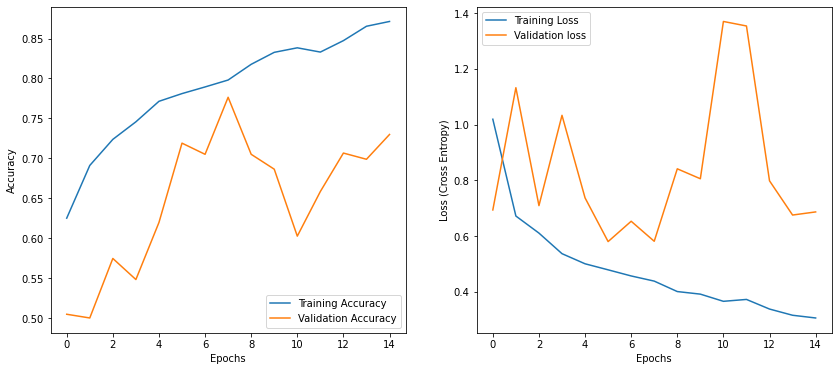

In [19]:
ds_alexnet, history_alexnet = train_and_evaluate("AlexNet", alexNet_model, epochs = 15, lr=1e-4)

### 2. VGG16

VGG16 is more of a classic network was introduced in 2014, refer to the original paper [VGG16](https://arxiv.org/pdf/1409.1556.pdf)

A nice thing about VGG16 is that the model always uses the same "same" convolutional layer and max pooling layer across the entire network:
- CONV = 3 x 3 filter, s = 1, same
- MAXPOOL = 2x2, s = 2

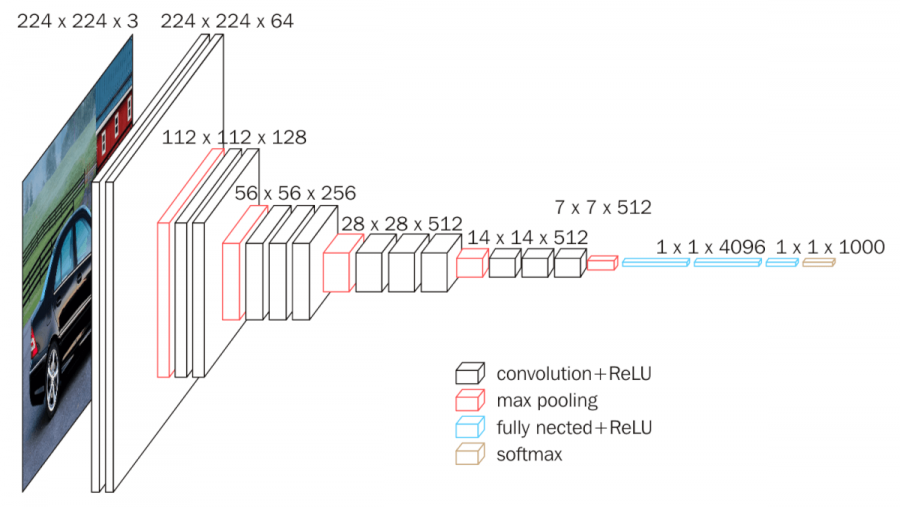

In [18]:
IMAGE_SHAPE = (224, 224, 3)
vgg16_model = hotdog_model("VGG16", IMAGE_SHAPE)
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 512)               0     

Found 3000 images belonging to 2 classes.
Found 644 images belonging to 2 classes.
Epoch 1/15
94/94 [==============================] - 565s 6s/step - loss: 3.3096 - accuracy: 0.4537 - val_loss: 2.6152 - val_accuracy: 0.4907
Epoch 2/15
94/94 [==============================] - 601s 6s/step - loss: 2.5795 - accuracy: 0.5137 - val_loss: 1.9620 - val_accuracy: 0.5621
Epoch 3/15
94/94 [==============================] - 656s 7s/step - loss: 2.1552 - accuracy: 0.5780 - val_loss: 1.5857 - val_accuracy: 0.6273
Epoch 4/15
94/94 [==============================] - 499s 5s/step - loss: 1.8668 - accuracy: 0.5997 - val_loss: 1.3384 - val_accuracy: 0.6724
Epoch 5/15
94/94 [==============================] - 560s 6s/step - loss: 1.6629 - accuracy: 0.6413 - val_loss: 1.1971 - val_accuracy: 0.7174
Epoch 6/15
94/94 [==============================] - 723s 8s/step - loss: 1.4830 - accuracy: 0.6673 - val_loss: 1.0952 - val_accuracy: 0.7391
Epoch 7/15
94/94 [==============================] - 715s 8s/step - loss

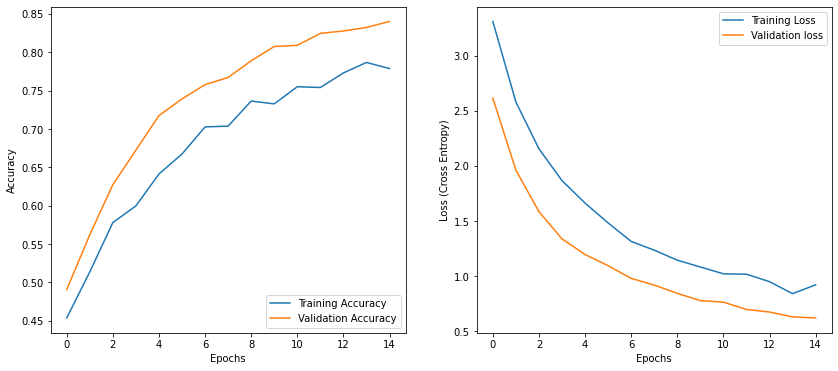

In [19]:
ds_vgg16, history_vgg16 = train_and_evaluate("VGG16", vgg16_model, epochs = 15, lr=1e-4)

### 3. MobileNet

Refer to the original paper [MobileNet](https://arxiv.org/pdf/1704.04861.pdf).

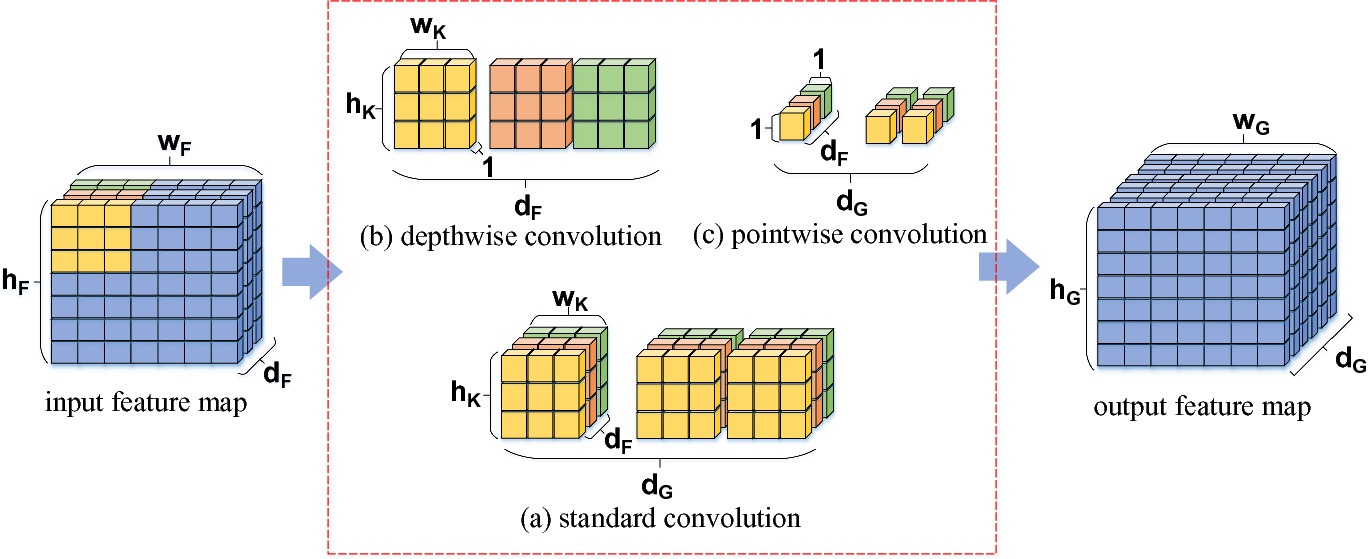

The key idea of MobileNet is: __Depthwise Separable Convolution__ which includes 2 steps:
   - Depthwise Convolution: applies a single filter to each channel of input
   - Pointwise Convolution: applies 1x1 convolution to combine outputs of depthwise conv

In __conventional convolution__, for example given:
- Input ($D_K \times D_K \times M$) = 6 x 6 x 3 
- filter size($D_F \times D_F$) = 3 x 3
- Number of filters ($N$) = 5
- stride = 1.

The output ($D_O \times D_O \times N$) will be  4 x 4 x 5 and the computational cost would be:

$Cost = D_F * D_F * M * D_O * D_O * N = 3 * 3 * 3 * 4 * 4 * 5 = 2160$

In __depthwise separable convolution__, we first apply __depthwise conv__ i.e one filter for each channel. In this case, we going to apply __one__ 3 x 3 convolution to each Red, Green and Blue channel, thus the ouput would be 4 x 4 x 3. The computational cost after this step is:

$Cost_{depthwise} = 3 * 3 * 4 * 4 * 3 = 432$

Second, we apply __pointwise conv__ to the ouput of depthwise conv (4 x 4 x 3) which is a conventional convolution with __1 x 1 filter__. In this case, we apply 5 filters of 1 x 1 conv. The output would be 4 x 4 x 5. The cost after this step is:

$Cost_{pointwise} = 1 * 1 * 3 * 4 * 4 * 5 = 240$

Hence the total cost of depthwise separable conv is 

$Total Cost = 432 + 240 = 672$

#### Network Architecture
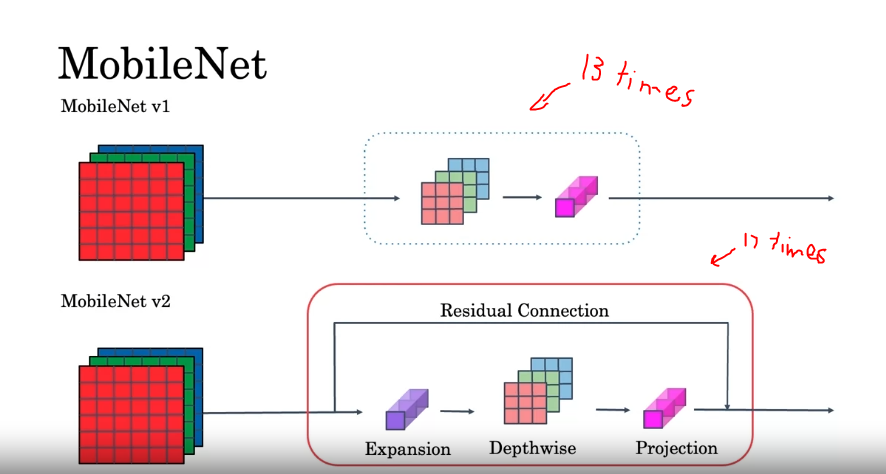

Each layer contains: 3 x 3 depthwise conv --> BatchNorm (BN) --> ReLU --> 1 x 1 pointwise conv --> BatchNorm --> ReLU. And this pattern is repeated several times (13 times in MobileNet v1), followed by a Average Pooling layer, Fully Connected and softmax layer as the output. 

In the MobileNetv2, which will be used in this project, the depthwise separable conv unit has an extra expansion layer before the depthwise and pointwise conv and a residual connection connected between the previous layer and next layer 



In [20]:
IMAGE_SHAPE = (160, 160, 3)
mobileNet_model = hotdog_model("MobileNet", IMAGE_SHAPE)
mobileNet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

Found 3000 images belonging to 2 classes.
Found 644 images belonging to 2 classes.
Epoch 1/15
94/94 [==============================] - 38s 389ms/step - loss: 0.5919 - accuracy: 0.6990 - val_loss: 0.4870 - val_accuracy: 0.7717
Epoch 2/15
94/94 [==============================] - 36s 380ms/step - loss: 0.4553 - accuracy: 0.7987 - val_loss: 0.3851 - val_accuracy: 0.8199
Epoch 3/15
94/94 [==============================] - 35s 376ms/step - loss: 0.3855 - accuracy: 0.8373 - val_loss: 0.3193 - val_accuracy: 0.8618
Epoch 4/15
94/94 [==============================] - 35s 375ms/step - loss: 0.3442 - accuracy: 0.8647 - val_loss: 0.2813 - val_accuracy: 0.8866
Epoch 5/15
94/94 [==============================] - 35s 373ms/step - loss: 0.3171 - accuracy: 0.8730 - val_loss: 0.2565 - val_accuracy: 0.8991
Epoch 6/15
94/94 [==============================] - 35s 374ms/step - loss: 0.2901 - accuracy: 0.8853 - val_loss: 0.2386 - val_accuracy: 0.9084
Epoch 7/15
94/94 [==============================] - 36s 378

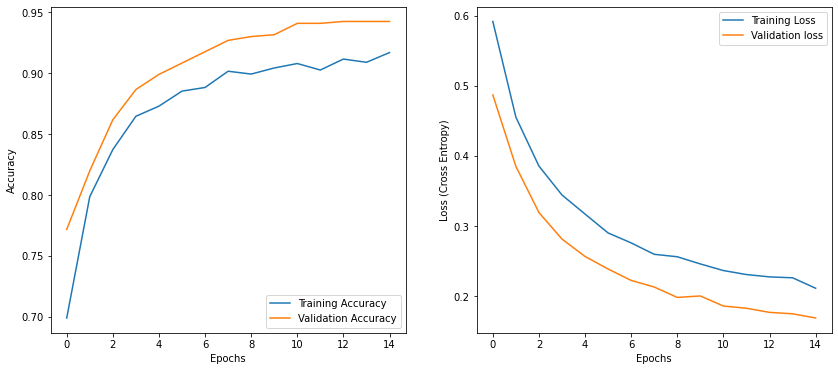

In [21]:
ds_mobilenet, history_mobilenet = train_and_evaluate("MobileNet", mobileNet_model, epochs = 15, lr=1e-4)

### 4. ResNet50

ResNet50 is a conventional convolutional neural network with 50 layers. Resnet50 was the first NN that introduced the concept of residual connection. Refer to the original paper [Resnet50](https://arxiv.org/pdf/1512.03385.pdf)

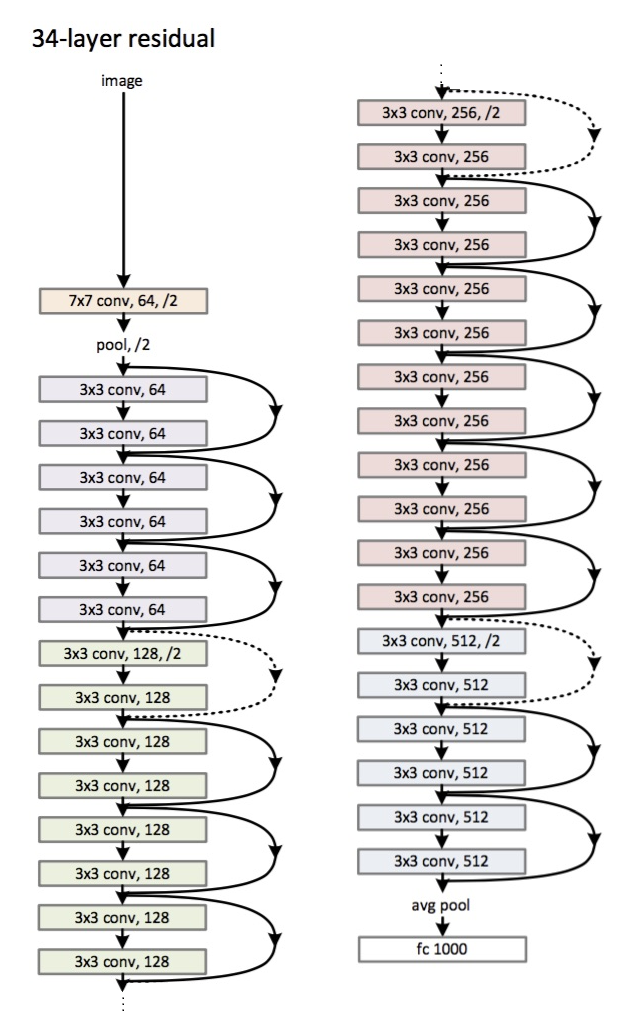

In [32]:
IMAGE_SHAPE = (224, 224, 3)
resNet_model = hotdog_model("ResNet50", IMAGE_SHAPE)
resNet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0     

Found 3000 images belonging to 2 classes.
Found 644 images belonging to 2 classes.
Epoch 1/15
94/94 [==============================] - 206s 2s/step - loss: 0.5531 - accuracy: 0.7247 - val_loss: 0.3631 - val_accuracy: 0.8509
Epoch 2/15
94/94 [==============================] - 230s 2s/step - loss: 0.4081 - accuracy: 0.8177 - val_loss: 0.2874 - val_accuracy: 0.9006
Epoch 3/15
94/94 [==============================] - 234s 2s/step - loss: 0.3404 - accuracy: 0.8543 - val_loss: 0.2476 - val_accuracy: 0.9193
Epoch 4/15
94/94 [==============================] - 254s 3s/step - loss: 0.3085 - accuracy: 0.8727 - val_loss: 0.2250 - val_accuracy: 0.9239
Epoch 5/15
94/94 [==============================] - 241s 3s/step - loss: 0.2823 - accuracy: 0.8783 - val_loss: 0.2039 - val_accuracy: 0.9301
Epoch 6/15
94/94 [==============================] - 230s 2s/step - loss: 0.2624 - accuracy: 0.8947 - val_loss: 0.1907 - val_accuracy: 0.9332
Epoch 7/15
94/94 [==============================] - 230s 2s/step - loss

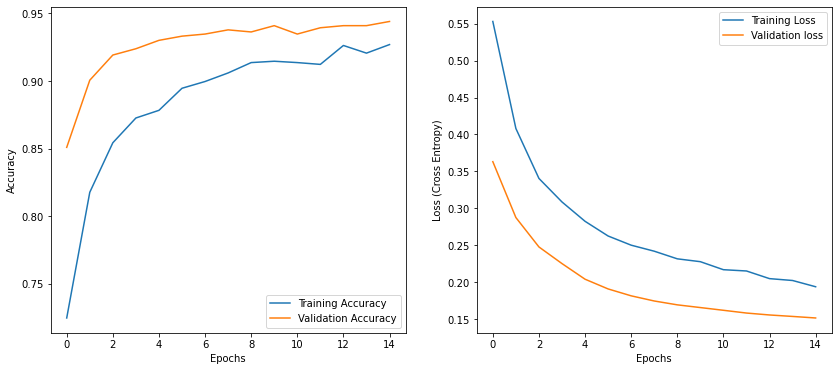

In [33]:
ds_resnet, history_resnet = train_and_evaluate("ResNet50", resNet_model, epochs = 15, lr=1e-4)

In [32]:
## Save the models
import os
savedmodel_dir = os.path.dirname("saved_model/")

alexNet_model.save('saved_model/alexnet.h5')
resNet_model.save('saved_model/resnet.h5')
mobileNet_model.save('saved_model/mobilenet.h5')
vgg16_model.save('saved_model/vgg16.h5')

### Comparing between models

The following table summarizes the outcome's accuracy of each model after training the top layer only (except AlexNet) in 15 epochs.

| Model | Trainable Params| Val Acc |
|:------   |:----------|:-------------|
| Dense                 | 27,791,361 | 65.4%
| AlexNet               | 58,285,441 | 73.0%
| VGG16 (top only)      | 513        | 86.3%
| ResNet50 (top only)   | 2049       | 93.8%
| MobileNetV2 (top only)| 1281       | 94.2%

- VGG16 and AlexNet could still improve further by running more epochs. 
- ResNet50 and MobileNetV2 has much better performance after same number of epochs. We will next fine tune these 2 layers to see if we can get even better result. 

## Fine Tuning the Model

The last step is to fine tune the top 2 models in the previous section by unfreezing some layers in each base model. Then we continue training the model for another 10 epochs. 

#### Load the trained model 

Since the project was done in multiples days, we need to load the trained model again

In [21]:
mobileNet_model = tf.keras.models.load_model('saved_model/mobilenet.h5')
resNet_model = tf.keras.models.load_model('saved_model/resnet.h5')

In [31]:
history = resNet_model.history
print(history)

None


In [25]:
#Extract the length of base layer in each model
base_model_mobilenet = mobileNet_model.layers[-4]
print("Length of MobileNetv2 base layers:", len(base_model_mobilenet.layers))
base_model_resnet = resNet_model.layers[-4]
print("Length of ResNet50 base layers:", len(base_model_resnet.layers))

Length of MobileNetv2 base layers: 154
Length of ResNet50 base layers: 175


Define __fine_tune()__ function that takes in: 
- trained model
- Dataset corresponding to each model(to make sure the image dimensions are appropriate)
- History after initial train
- Number of layers to freeze
- Number of additional epochs to fine tune

In [34]:
def fine_tune(model, dataset, history, FINE_TUNE_LAYERS, FINE_TUNE_EPOCHS):
    base_layer = model.layers[-4]
    base_layer.trainable=True
    for layer in base_layer.layers[:FINE_TUNE_LAYERS]:
        layer.trainable=False
    
    print(model.summary())
    lr = 1e-4
    
    train_dataset, validation_dataset = dataset
    #FINE_TUNE_EPOCHS = 5
    TOTAL_EPOCHS = 15 + FINE_TUNE_EPOCHS
    history2 = model.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs = TOTAL_EPOCHS,
                          initial_epoch = history.epoch[-1])
    
    plot_accuracy_loss(history2)


__Fine tune MobileNet__

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

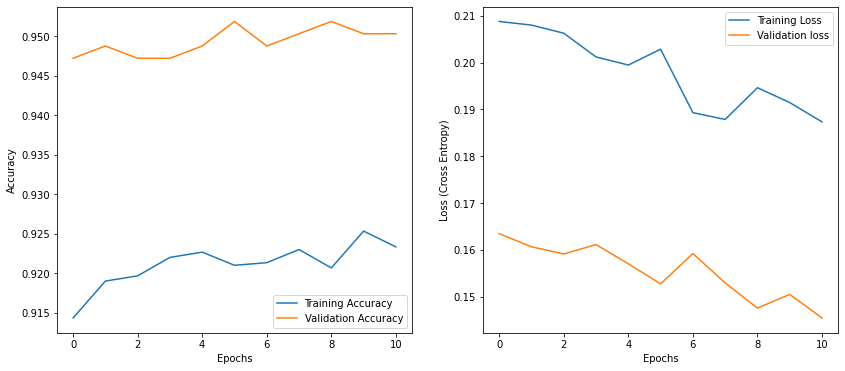

In [49]:
fine_tune(mobileNet_model, ds_mobilenet, history_mobilenet, 100, 10)

__Fine tune resNet50__

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0     

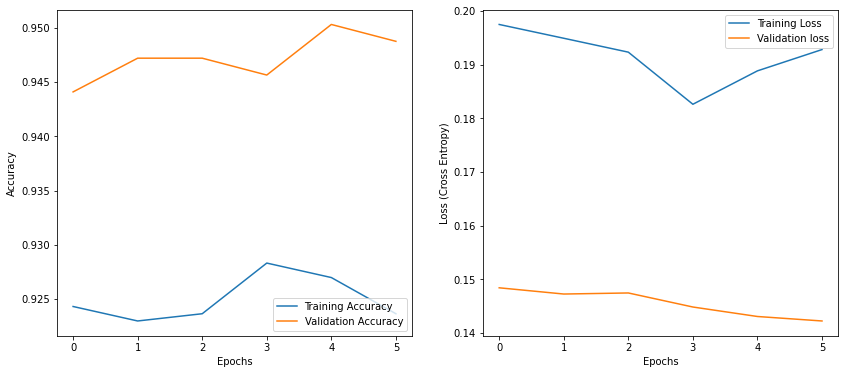

In [35]:
fine_tune(resNet_model, ds_resnet, history_resnet, 125, 5)

__Results__

After 5 extra epochs fine tuning the last 75 and 54 layers of ResNet the MobileNet respectively, we slightlt imrpoved the performance:

| Model | Trainable Params|Val Acc (initial)| Val Acc (final) |
|:-----------------------|:-----------|:-------------|:-------|
| ResNet                 | 19,454,977 | 93.8%        |95.0%
| MobileNetv2            | 58,285,441 | 94.2%        | 94.7%



## Conclusion

Both __ResNet__ and __MobileNetV2__, which are non-classic models in Deep Learning, has similar performance. Although __VGG16__ and __AlexNet__, which are classic model in Deep Learning, performs worse, its performance can still be better by running more epochs.

Hopefully this makes Erlich Bachman happy!.